In [48]:
# default_exp data.load_pd

In [49]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [50]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [51]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [52]:
# export
import numpy as np
import pandas as pd

## Utils

In [53]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [54]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [55]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [56]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

## Types

In [57]:
class TSeries(TensorBase):pass

In [58]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [59]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = L(self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)]))
        labels = L(self._meta.get('label',['x']*len(arrays)))
        assert len(m)==len(labels)==len(arrays),f"{len(m)}=={len(labels)}=={len(arrays)}" 
        t = np.arange(array.shape[1])        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)
        ctx.legend()
        return ctx
class TensorSeqsX(TensorSeqs):pass

In [60]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

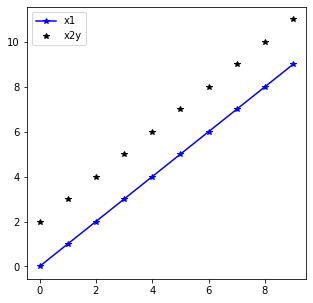

In [61]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

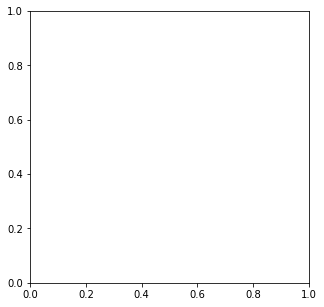

In [62]:
# hide
test_fail(TensorSeqs(torch.randn(2,10), m='b', label = ['x1','y2']).show)

In [63]:
# export
def _get_its_shape(o):    
    if len(o.shape) == 0: return 1, o[None]
    return len(o), o
    
class TensorCon(TSeries):
    _name = 'Constant'
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        l, its = _get_its_shape(self)
        dct = {k:its[i].item() for k,i in zip(L(self._meta.get('label',self._name)),range(l))}
        ax.set_title(ax.title._text +f"{dct}")
        return ax

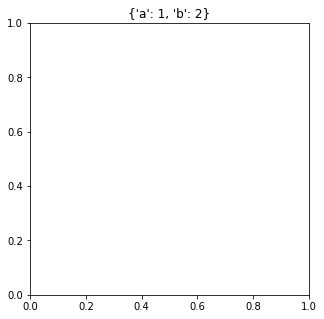

In [64]:
TensorCon([1,2], label=['a','b']).show()

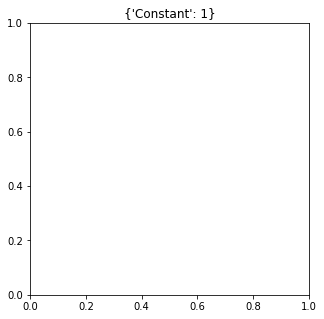

In [65]:
TensorCon(1).show()

In [66]:
# export
class TensorCat(TensorCon):
    _name = 'Catagory'

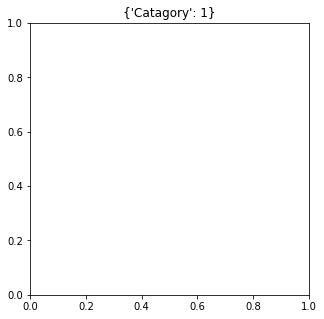

In [67]:
TensorCat(1).show()

## MultiTuple

In [68]:
# export
class MultiTuple(Tuple):
    """The same as `Tuple` only stores the types in `_types` and if _meta stores those in `_meta`"""
    def __new__(cls, x, *rest, **kwargs):
        r = Tuple.__new__(cls,x, *rest)
        r._meta = {i:a._meta for i,a in enumerate(L(r)) if hasattr(a,'_meta')}
        r._types = [type(a) for a in L(r)]
        return r

In [69]:
o = MultiTuple(1)
o, o._meta, o._types

((1), {}, [int])

In [70]:
a = TensorBase(tensor(1), label='x')
b = TensorBase(tensor(1), label='y')
print(a._meta)
o = MultiTuple((a,b))
o, getattr(o,'_meta',None), o._types

{'label': 'x'}


((TensorBase(1), TensorBase(1)),
 {0: {'label': 'x'}, 1: {'label': 'y'}},
 [fastai2.torch_core.TensorBase, fastai2.torch_core.TensorBase])

In [71]:
# hide
test_eq(o._meta,{0: {'label': 'x'}, 1: {'label': 'y'}})
test_eq(o._types,[TensorBase, TensorBase])
o = MultiTuple(1)
test_eq(o._meta,{})
test_eq(o._types,[int])

In [72]:
# export

from fastai2.vision.data import get_grid
from fastseq.core import *
def _show_multituple(t, ax):
    for o in t:
        ax = o.show(ctx = ax)
    return ax

def get_ax(ax, ctx, figsize, **kwargs):
    ax = ifnone(ax,ctx)
    if ax is None:
        _, ax = plt.subplots(figsize=figsize, **kwargs)
    return ax

@delegates(plt.subplots)
def show_mt(self, ax = None, ctx=None, figsize = (10,10), **kwargs):
    ax = get_ax(ax, ctx, figsize, **kwargs)
    return _show_multituple(self, ax)   
MultiTuple.show = show_mt

In [73]:
show_doc(MultiTuple.show,name='MultiTuple.show')

<h4 id="MultiTuple.show" class="doc_header"><code>MultiTuple.show</code><a href="__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiTuple.show</code>(**`ax`**=*`None`*, **`ctx`**=*`None`*, **`figsize`**=*`(10, 10)`*, **`nrows`**=*`1`*, **`ncols`**=*`1`*, **`sharex`**=*`False`*, **`sharey`**=*`False`*, **`squeeze`**=*`True`*, **`subplot_kw`**=*`None`*, **`gridspec_kw`**=*`None`*)



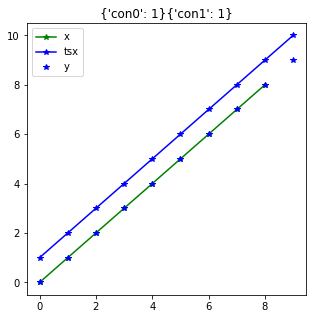

In [74]:
x,xts,a,b = TensorSeqs(np.arange(9)[None,:],label=['x'],m=['g']),TensorSeqs(np.arange(1,11)[None,:],label=['tsx']), TensorCon(1,label=['con0']),TensorCon(1, label=['con1'], m='r')
y = TensorSeqs(np.arange(10)[None,:],label=['y'])
MultiTuple(x,xts,a,b,y).show(figsize = (5,5))

In [75]:
# export
class TSMulti(MultiTuple):pass

# Dataloader

In [76]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= None, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []      

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def check_std(self, r):  
        if self.max_std is not None:
            if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
                if idx not in self.skipped:
                    self.skipped.append(idx)
                raise SkipItemException()
        
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx, label=self.ts_names)]
        if len(self.cat_names):
            r.append(TensorCon(row[self.cat_names].to_numpy().astype(float),label=self.cat_names))
        if len(self.con_names):
            # TODO make cat its own type
            r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name+ '_y'], m=['g']))
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        self.check_std(r)     
        return TSMulti(r)
        
    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [77]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 -0.111701 1 1.735086 2 2.154928 3 3.832620 4 5.073939 5 6.313672 6 7.585284 7 7.602713 8 7.613667 9 8.976300 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 0.272207 1 0.648862 2 4.354973 3 3.315513 4 5.161772 5 5.647221 6 6.694840 7 6.609370 8 7.323160 9 11.368638 10 12.386290 11 12.818813 dtype: float64,1.0,1


In [78]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [79]:
for o in dl:
    test_eq(type(o), TSMulti)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    break

In [80]:
# hide
# without cat or con
horizon,lookback = 3,5
dl = DfDataLoader(df[['pred','ts_0']], 'pred', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), TSMulti)
    test_eq(len(o),3)
    dct = {k:v for k,v in zip(['x','tsx','y'], o)}
    test_eq(type(o), TSMulti)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    
test_eq(first(dl), dl.one_batch())

In [81]:
# hide
# test self.new
dl.new()

## Showing

In [82]:
# export
@typedispatch
def show_batch(x:TSMulti, none_1, none_2, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o._meta) for o in x])
        ctx = o.show(ctx=ctx)
    return ctxs


Need to pad 1/2 time series due to length.


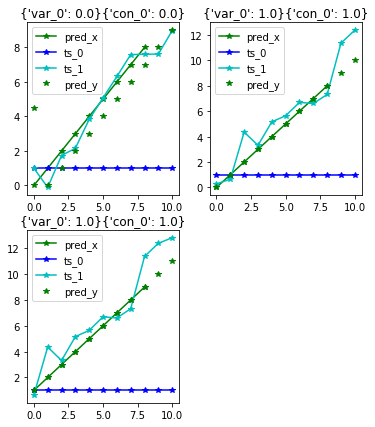

In [83]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)
dl.show_batch()

In [84]:
#export
from fastseq.data.load_pd import *
from fastai2.vision.data import get_grid

@typedispatch
def show_results(x:TSMulti, x1, none_1, none_2, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o[i],**o._meta) for o in x]
        r.append(type(x1[-1])(x1[-1][i],label=['pred'],m=['r']))
        o = TSMulti(r)
        ctx = o.show(ctx=ctx)
        


(#4) [0,269.4277648925781,247.330078125,'00:00']
Need to pad 1/2 time series due to length.
Need to pad 1/2 time series due to length.
<class '__main__.TensorSeqs'>
<class '__main__.TensorSeqs'>
<class '__main__.TensorCon'>
<class '__main__.TensorCon'>
<class '__main__.TensorSeqs'>
<class '__main__.TensorCon'>
<class '__main__.TensorSeqs'>
<class '__main__.TensorSeqs'>
<class '__main__.TensorCon'>
<class '__main__.TensorCon'>
<class '__main__.TensorSeqs'>
<class '__main__.TensorCon'>
<class '__main__.TensorSeqs'>
<class '__main__.TensorSeqs'>
<class '__main__.TensorCon'>
<class '__main__.TensorCon'>
<class '__main__.TensorSeqs'>
<class '__main__.TensorCon'>


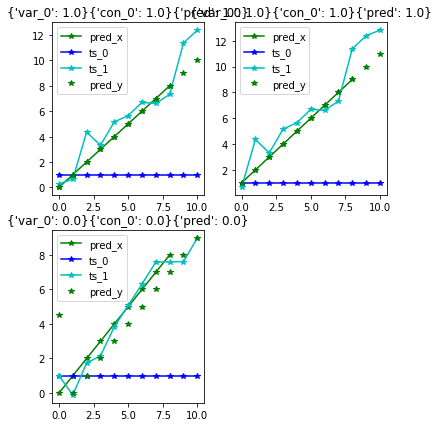

In [85]:
class RegModel(Module):
    def __init__(self,in_f,out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)

learn = synth_learner(lookback, horizon, data=DataLoaders(dl,dl))
learn.fit(1)
learn.show_results(max_n=9)

# Intergration Example

In [86]:
from fastseq.data.external import *

In [87]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df['city_int'] = df['city'].astype(int) 
df['city'] = df['city'].astype(float)
df.head()

,x,weather,city,cont,city_int
0,"[[0.894125177103785, 0.5645616971619006, 0.4235302197157468, 0.7152987679533493, 0.5557172135073182, 0.4493113827645251, 0.6999689005684351, 0.7772759928422984, 1.613639043195928, 1.1336975813563457, -0.15198836721817635, -1.508756641847106, -1.9518856970049163, -2.082311041883505, -1.0850834478512827, -0.5580712875782228, 0.2889103318866962, 1.1666487960366423, 1.434974198566631, 1.5123577501918788, 1.2366722733151991, 0.5092152103850797, -0.6515269996180301, -0.6443651919212454, -0.5482925816424428, -0.838323700028951, -0.7845594542431988, -1.1008724897222881, -1.0417147125708295, -0.469...","[[6.245002510564312, 5.751839755739069, 5.783547153135041, 6.015943801942821, 5.407004912427528, 4.0564900807573405, 3.5015031163274273, 4.752716182416189, 6.678954175929579, 7.117311789838604, 5.474511902210492, 3.481074680910732, 3.0995506177646366, 4.279210097528843, 5.351187773473713, 5.302915552217146, 6.245002510564312, 5.751839755739069, 5.783547153135041, 6.015943801942821, 5.407004912427528, 4.0564900807573405, 3.5015031163274273, 4.752716182416189, 6.678954175929579, 7.117311789838604, 5.474511902210492, 3.481074680910732, 3.0995506177646366, 4.279210097528843, 5.351187773473713,...",0.0,-1.763334,0
1,"[[-0.6732121288923265, -0.29053943378765196, -0.29911829203338774, -1.0539158617425652, -0.374873763971887, -1.7603630809624917, -1.3964104794768168, -0.6239576325123805, 0.245312062841614, 0.947638597330224, 0.3228145106562806, -0.6015949016916067, -0.5029101428037503, 0.7735749617113369, 1.4429450127602017, 1.017378501927477, 1.8693081846437978, 0.8885197670106333, 0.7622048325869607, 1.9993556193508335, 0.48568320848438845, -0.14147464312704333, 0.12141650535281727, 0.3186031161925724, 1.000014811965591, 1.1645168374380397, -0.5640774493571856, -1.2213100754400377, -2.055957156304893, -...","[[3.553102979080805, 3.10820308392777, 3.1771467332822487, 3.4148651987875196, 2.805328420769447, 1.503971561918873, 1.0608078190063557, 2.426105232795636, 4.396947506964085, 4.810429334482709, 3.145014786647325, 1.1916281538380686, 0.899910540504874, 2.163456764881706, 3.2874067501781905, 3.280080230559535, 3.553102979080805, 3.10820308392777, 3.1771467332822487, 3.4148651987875196, 2.805328420769447, 1.503971561918873, 1.0608078190063557, 2.426105232795636, 4.396947506964085, 4.810429334482709, 3.145014786647325, 1.1916281538380686, 0.899910540504874, 2.163456764881706, 3.287406750178190...",0.0,0.486386,0
2,"[[1.3048396733975225, 0.5587652736720717, 0.5496216635258127, 0.25029426224020873, 1.0058835107875888, 0.7667243084082311, 0.7680139452022465, 0.9409239722953678, 1.054014119343998, 0.4105374901970989, -0.4813610943506566, -1.4858954687341916, -1.945106480623364, -1.6936322057613127, -1.0467876218121523, -0.6268636226946248, 0.38094560625521406, 0.8726017001665342, 1.2194535471838728, 1.78048269922914, 1.2241642558638688, 0.8293203425382618, -0.10887920248878369, -0.7112165858950688, -0.8947904681807877, -1.134061721386065, -1.3980963403282252, -1.2189932663864915, -0.9154870890777994, -0....","[[10.146264741734612, 9.089506687538606, 8.856721008589403, 9.549910210843642, 9.875239805658929, 9.151725489506896, 8.306651716787762, 8.441698578708635, 9.06531972989426, 8.624816329501702, 6.739044823118986, 5.031201179985433, 5.247092927794139, 7.048616172817686, 8.40850880104783, 8.104375165277515, 10.146264741734612, 9.089506687538606, 8.856721008589403, 9.549910210843642, 9.875239805658929, 9.151725489506896, 8.306651716787762, 8.441698578708635, 9.06531972989426, 8.624816329501702, 6.739044823118986, 5.031201179985433, 5.247092927794139, 7.048616172817686, 8.40850880104783, 8.10437...",0.0,0.767419,0
3,"[[0.6626829173019194, 0.4176851225382387, -0.0919920808628707, 0.16930810921728923, 0.3656707750971717, 0.901088599381698, 1.50536442588069, 1.8173989659957406, 1.4500124816755047, 1.1600368772032024, 0.7827815366195344, 0.4683223900206932, 0.07881356696954905, -0.5482052544218077, -0.9436096360252192,

<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorCon'>
Constant
<class 'fastseq.data.load_pd.TensorCon'>
Constant
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorCon'>
Constant
<class 'fastseq.data.load_pd.TensorCon'>
Constant
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorCon'>
Constant
<class 'fastseq.data.load_pd.TensorCon'>
Constant
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorCon'>
Constant
<class 'fastseq.data.load_pd.TensorCon'>
Constant
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fastseq.data.load_pd.TensorSeqs'>
<class 'fast

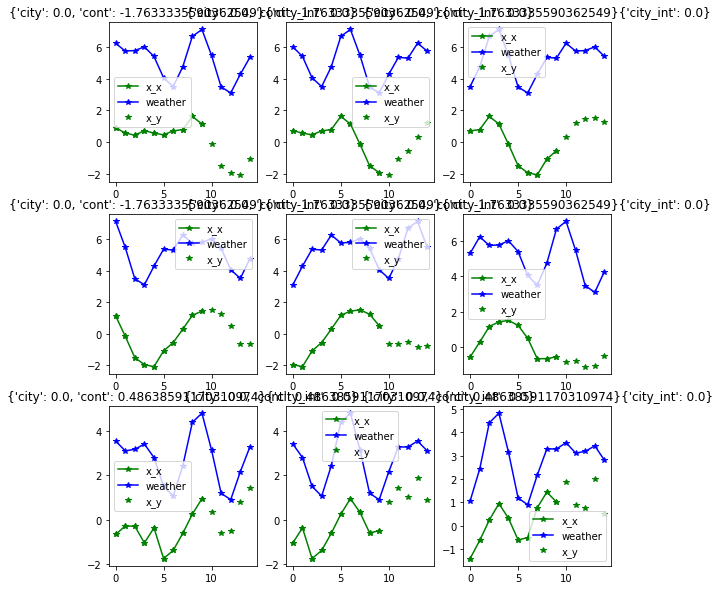

In [88]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

In [89]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
